# Decision Tree I - Predicting Customer Satisfaction


In this activity, I’ll build a decision tree model that makes predictions for a target based on multiple features.

An airline is interested in predicting whether a future customer would be satisfied with their services given customer feedback given previous customer feedback about their flight experience. The airline would like you to construct and evaluate a model that can accomplish this goal. Specifically, they are interested in knowing which features are most important to customer satisfaction.

The data for this activity includes survey responses from 129,880 customers of an airline. It includes data points such as class, flight distance, and in-flight entertainment, among others. In a previous activity, I utilized a binomial logistic regression model to help the airline better understand this data. In this activity, my goal will be to utilize a decision tree model to predict whether or not a customer will be satisfied with their flight experience. 

Because this activity uses a dataset from the industry, I will need to conduct basic EDA, data cleaning, and other manipulations to prepare the data for modeling.

## Import relevant packages

In [1]:
# Standard operational package imports
import numpy as np
import pandas as pd

# Important imports for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import sklearn.metrics as metrics

# Visualization package imports
import matplotlib.pyplot as plt
import seaborn as sns

## Load the dataset

In [2]:
df = pd.read_csv("Data//Invistico_Airline.csv")
df.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


## Data exploration, cleaning, and preparation
After loading the dataset, prepare the data to be suitable for decision tree classifiers. This includes: 
*   Exploring the data
*   Checking for missing values
*   Encoding the data
*   Renaming a column
*   Creating the training and testing data

### Explore the data

In [4]:
# Check the data type of each column
df.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

### Output unique values 

The `Class` column is ordinal (meaning there is an inherent order that is significant). For example, airlines typically charge more for 'Business' than 'Eco Plus' and 'Eco'. Output the unique values in the `Class` column. 

In [6]:
df["Class"].unique()

array(['Eco', 'Business', 'Eco Plus'], dtype=object)

### Check the counts of the predicted labels

In order to predict customer satisfaction, verify if the dataset is imbalanced. To do this, check the counts of each of the predicted labels. 

In [7]:
df['satisfaction'].value_counts(dropna = False)

satisfaction
satisfied       71087
dissatisfied    58793
Name: count, dtype: int64

**Question:** What percentage of customers were satisfied? 

54.7 percent (71087/129880) of customers were satisfied. This value can be compared to a decision tree's model accuracy. 

### Check for missing values

The sklearn decision tree implementation does not support missing values. Check for missing values in the rows of the data. 

In [8]:
df.isnull().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

**Question:** Why is it important to check how many rows and columns there are in the dataset? 

This is important to check because if there are only a small number of missing values in the dataset, they can more safely be removed. 

### Check the number of rows and columns in the dataset

In [10]:
df.shape

(129880, 22)

The number of rows with missing values is low compared with the rows in the dataset. Hence we can safely remove the rows with null values.

### Drop the rows with missing values

In [11]:
df_clean = df.dropna(axis=0).reset_index(drop = True)
df_clean.isna().sum()


satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

In [12]:
df_clean.shape

(129487, 22)

### Encode the data

Four columns (`satisfaction`, `Customer Type`, `Type of Travel`, `Class`) are the pandas dtype object. Decision trees need numeric columns. Start by converting the ordinal `Class` column into numeric. 

In [14]:
df_clean['Class'] = df_clean['Class'].map({"Business": 3, "Eco Plus": 2, "Eco": 1}) 

### Represent the data in the target variable numerically

To represent the data in the target variable numerically, assign `"satisfied"` to the label `1` and `"unsatisfied"` to the label `0` in the `satisfaction` column. 

In [15]:
df_clean['satisfaction'] = df_clean['satisfaction'].map({"satisfied": 1, "dissatisfied": 0})

### Convert categorical columns into numeric

There are other columns in the dataset that are still categorical. Be sure to convert categorical columns in the dataset into numeric.

In [16]:
df_clean = pd.get_dummies(df_clean, drop_first = True)

### Check column data types

In [17]:
df_clean.dtypes

satisfaction                           int64
Age                                    int64
Class                                  int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
Customer Type_disloyal Customer         bool
Type of Travel_Personal Travel          bool
dtype: obj

### Create the training and testing data

In [18]:
y = df_clean["satisfaction"]

X = df_clean.copy()
X = X.drop("satisfaction", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Model building

### Fit a decision tree classifier model to the data

In [19]:
decision_tree = DecisionTreeClassifier(random_state=0)

decision_tree.fit(X_train, y_train)

dt_pred = decision_tree.predict(X_test)

**Question:** What are some advantages of using decision trees versus other models? 

Decision trees require no assumptions regarding the distribution of underlying data and don't require scaling of features. This lab uses decision trees because there is no need for additional data processing, unlike some other models. 

## Results and evaluation

In [21]:
print("Decision Tree:")
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, dt_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, dt_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, dt_pred))

Decision Tree:
Accuracy: 0.935438
Precision: 0.942859
Recall: 0.939030
F1 Score: 0.940940


**Question:** Are there any additional steps you could take to improve the performance or function of your decision tree?

Decision trees can be particularly susceptible to overfitting. Combining hyperparameter tuning and grid search can help ensure this doesn't happen. For instance, setting an appropriate value for max depth could potentially help reduce a decision tree's overfitting problem by limiting how deep a tree can grow. 

### Produce a confusion matrix

Data professionals often like to know the types of errors made by an algorithm. To obtain this information, produce a confusion matrix.

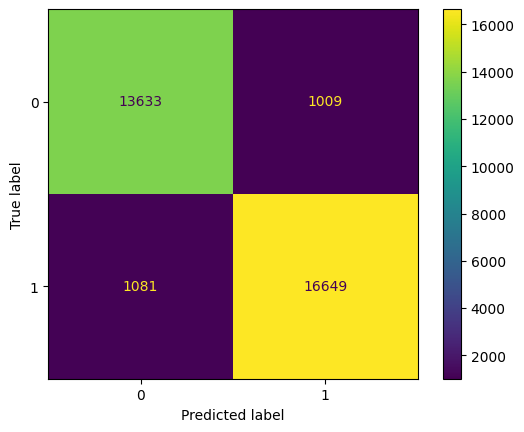

In [22]:
cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)
disp.plot()

**Question:** What patterns can you identify between true positives and true negatives, as well as false positives and false negatives?

In the confusion matrix, there are a high proportion of true positives and true negatives (where the matrix accurately predicted that the customer would be satisfied or dissatified, respectively). 

The matrix also had a relatively low number of false positives and false negatives (where the matrix innacurately predicted that the customer would be satisfied or dissatified, respectively.) 

### Plot the decision tree

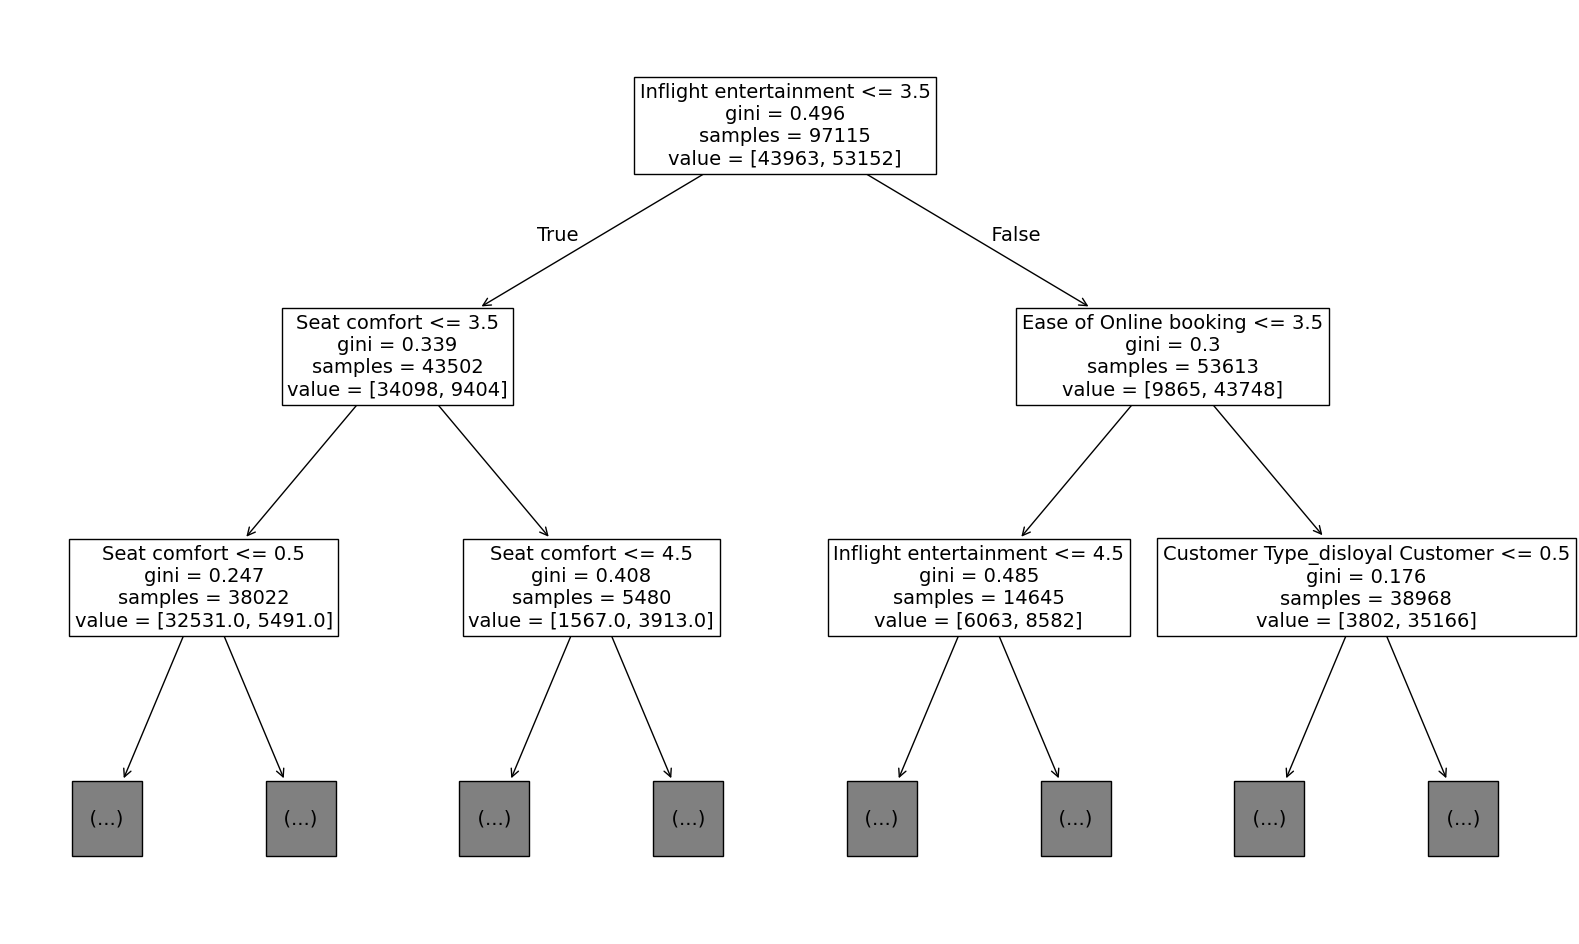

In [23]:
plt.figure(figsize=(20,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns);

### Build a feature importance graph

Uncover which features might be most important to your decision tree model by building a feature importance graph. 

<Axes: >

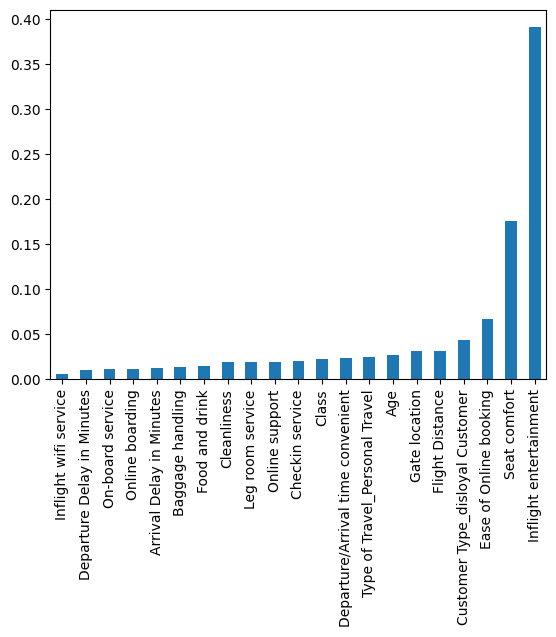

In [29]:
importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values()

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

**Question:** Based on the feature importance graph, which features are the most important for this model?

The feature importance graph seems to confirm that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features for this model. 

### Hyperparameter tuning

In [33]:
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]}

scoring = ['accuracy', 'precision', 'recall', 'f1']

**Note:** This cell may take up to 15 minutes to run.

In [34]:
tuned_decision_tree = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 30, 40,
                                       50],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                              20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

### Compute the best combination of values for the hyperparameters

In [35]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, random_state=0)

### Determine the best average validation score

In [36]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.9454


### Determine the "best" decision tree model's accuracy, precision, recall, and F1 score

In [39]:

results = pd.DataFrame(columns=['Model', 'F1', 'Recall', 'Precision', 'Accuracy'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    """

    # Get all the results from the CV and put them in a df.
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score).
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create a table of results.
    table = pd.Series({'Model': model_name,
                          'F1': f1,
                          'Recall': recall,
                          'Precision': precision,
                          'Accuracy': accuracy})

    return table

result_table = make_results("Tuned Decision Tree", clf)

result_table

Model        Tuned Decision Tree
F1                      0.945422
Recall                  0.935863
Precision               0.955197
Accuracy                0.940864
dtype: object

**Question:** Was the additional performance improvement from hyperparameter tuning worth the computational cost? Why or why not?

The F1 score for the decision tree that was not hyperparameter tuned is 0.940940 and the F1 score for the hyperparameter-tuned decision tree is 0.945422. While ensuring that overfitting doesn't occur is necessary for some models, it didn't make a meaningful difference in improving this model. 

### Plot the "best" decision tree

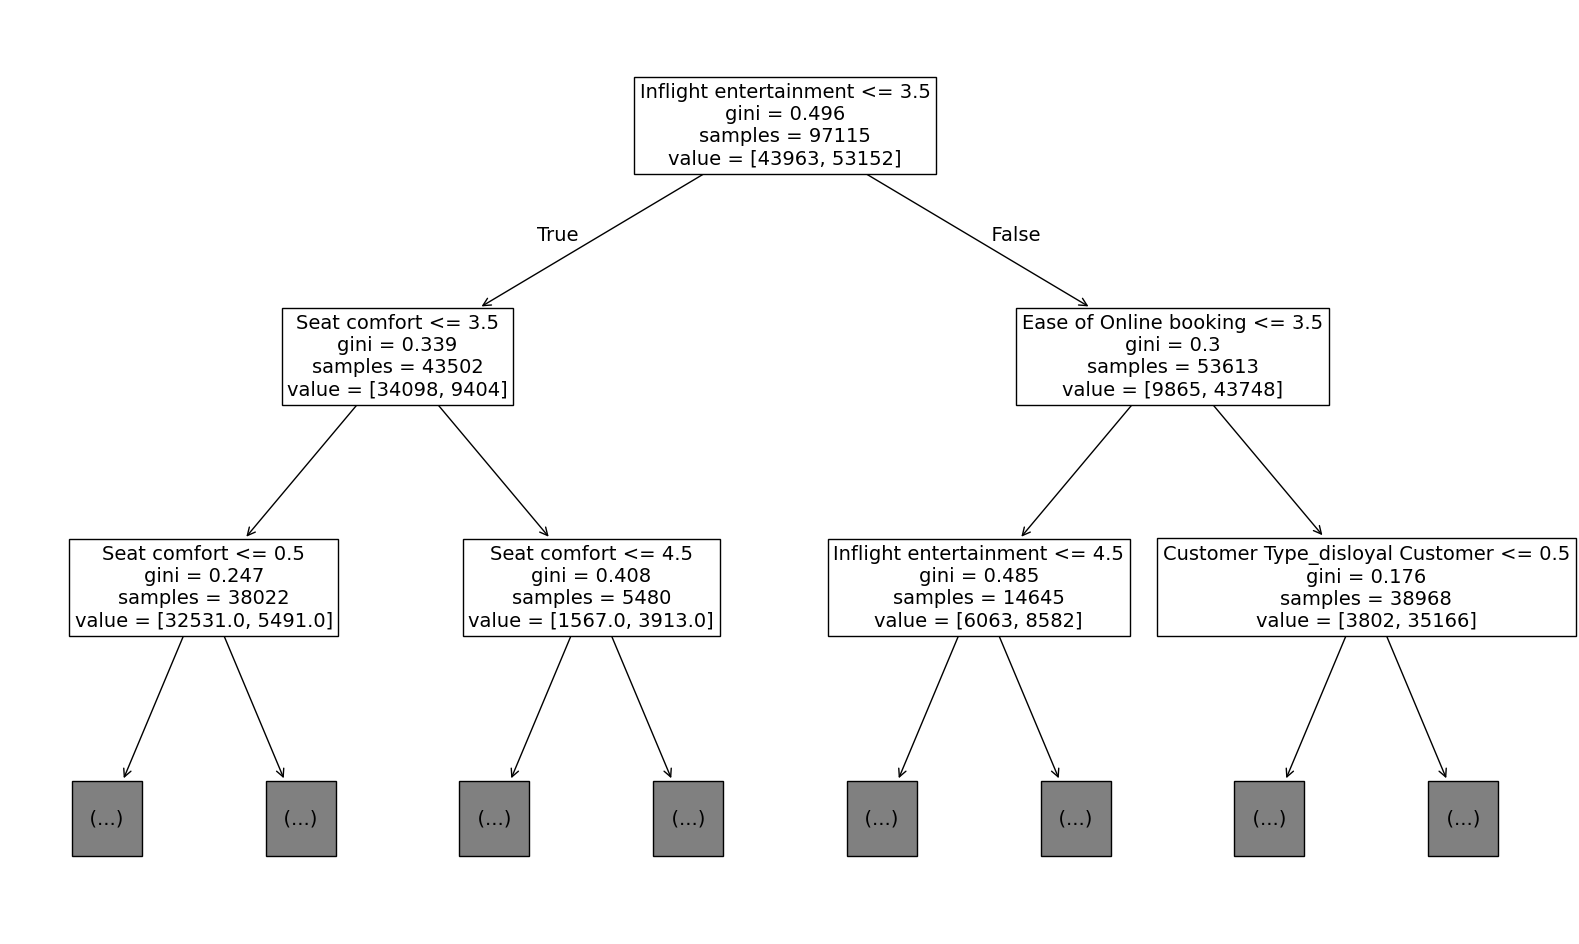

In [40]:
plt.figure(figsize=(20,12))
plot_tree(clf.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns);

The plot makes it seem like `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are among the most important features. The code below outputs a "most important" features graph from the model.

### Build another feature importance graph

<Axes: >

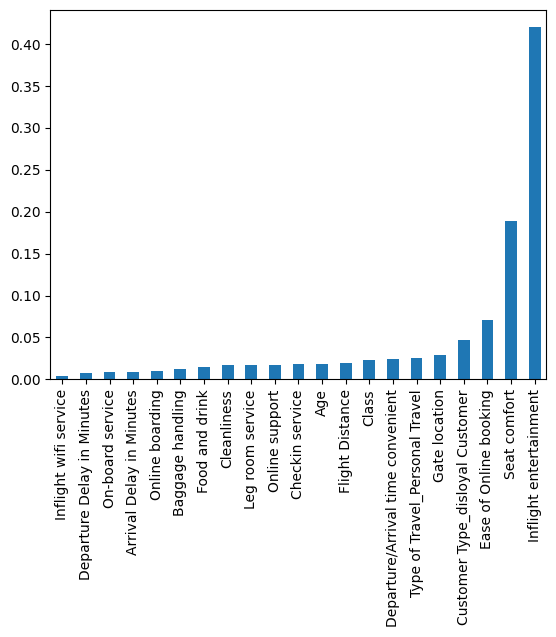

In [42]:
importances = clf.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values()

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

**Question:** Did the feature importance graph confirm your most important features? 

Yes. The feature importance graph seems to confirm that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the "most important" features for this model. 

**Question:** What do you think is the most important metric in this business case?

Any of the metrics in this business case could be considered important, depending on what the stakeholder or domain expert cares about. The following are reasons why each metric is important: 

- Accuracy tends to be the metric that the stakeholders can best understand.

- Precision measures what proportion of predicted positives is truly positive. For example, if you wanted to not falsely claiming a customer is satisfied, precision would be a good metric. Assuming a customer is happy when they are really not might lead to customer churn. 

- Recall measures the percentage of actual positives a model correctly identified (true positive). For this dataset, the airline might want to limit false negatives (actually satisfied people who are predicted to be unsatisfied). Assuming a customer is unhappy when the customer is happy can lead to the airline wasting resources trying to improve the customer experience of an already happy customer. 

- F1 balances precision and recall. It is the harmonic mean of precision and recall, or their product divided by their sum.

## Considerations

**What are some key takeaways that you learned from this lab?**
*   Machine learning workflows may be used to clean and encode data for machine learning.
*   While hyperparameter tuning can lead to an increase in performance, it doesn't always. 
*   The visualization of the decision tree as well as the feature graph can be used to determine which features are most important for a decision tree.


**What findings would you share with others?**
*   Decision trees accurately predicted satisfaction over 94 percent of the time.  
*   The confusion matrix is useful as it shows a similar number of true positives and true negatives. 
*   The visualization of the decision tree and the feature importance graph both suggest that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features in the model.

**What would you recommend to stakeholders?**
*  Customer satisfaction is highly tied to `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'`. Improving these experiences should lead to better customer satisfaction. 
*  The success of the model suggests that the airline should invest more effort into model building and model understanding since this model semed to be very good at predicting customer satisfaction. 